In [19]:
import cv2

def FrameCapture(path):
    vidObj = cv2.VideoCapture(path)
    frames = []
    success = 1
    count = 0

    while success:
        success, image = vidObj.read()
        if success:
            frames.append(image)
            count += 1

    return frames

In [14]:
frames_list = FrameCapture("Lab11/sample1.mp4")
print(f"Total frames captured: {len(frames_list)}")

Total frames captured: 197


Sample Frames:


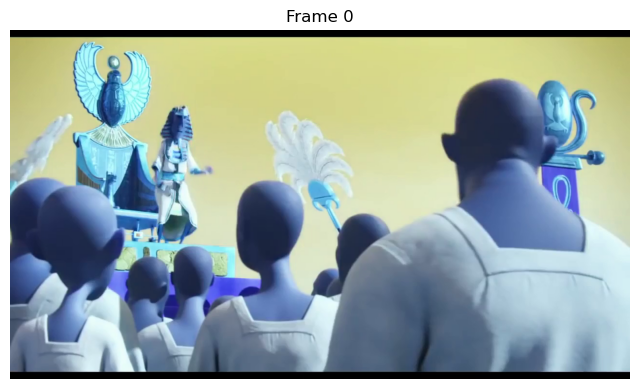

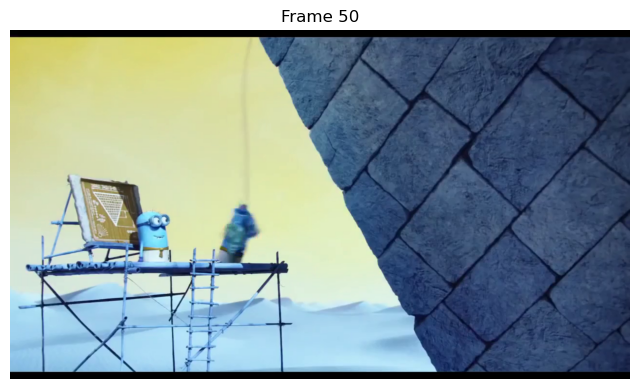

In [15]:
import matplotlib.pyplot as plt

def display_sample_frames(frames_list):
    plt.figure(figsize=(8, 8))
    plt.imshow(frames_list[0])
    plt.title("Frame 0")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.imshow(frames_list[50])
    plt.title("Frame 50")
    plt.axis('off')
    plt.show()

print("Sample Frames:")
display_sample_frames(frames_list)

In [16]:
diff_list = []
for i in range(len(frames_list)-1):
    frame1_gray = cv2.cvtColor(frames_list[i], cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frames_list[i+1], cv2.COLOR_BGR2GRAY)
    
    frame_diff = cv2.absdiff(frame2_gray, frame1_gray)
    diff_list.append(frame_diff)

In [19]:
import cv2
import numpy as np

output_video_path = 'output_video.avi'
fps = 30  # Frames per second
frame_width, frame_height = frames_list[0].shape[1], frames_list[0].shape[0]
output_video_size = (frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter(output_video_path, fourcc, fps, output_video_size)

for frame_diff in diff_list:
    frame_diff = np.clip(frame_diff, 0, 255).astype(np.uint8)
    
    if len(frame_diff.shape) == 2:
        frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_GRAY2BGR)
    
    out.write(frame_diff)

out.release()

print("Video created successfully!")


Video created successfully!


Edge Difference

In [1]:
import numpy as np

def convolve(img, kernel):
    m, n = img.shape
    km, kn = kernel.shape
    pad_img = np.pad(img, ((km//2, km//2), (kn//2, kn//2)), mode='constant')

    result = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            result[i, j] = np.sum(pad_img[i:i+km, j:j+kn] * kernel)

    return result

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)


In [2]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    return (1 / (2.0 * np.pi * sigma**2)) * np.exp(-((x**2 + y**2) / (2.0*sigma**2)))

In [3]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
          q=255
          r=255
          if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            q = img[i, j+1]
            r = img[i, j-1]
          elif (22.5 <= angle[i,j] < 67.5):
            q = img[i+1, j-1]
            r = img[i-1, j+1]
          elif (67.5 <= angle[i,j] < 112.5):
            q = img[i+1, j]
            r = img[i-1, j]
          elif (112.5 <= angle[i,j] < 157.5):
            q = img[i-1, j-1]
            r = img[i+1, j+1]

          if (img[i,j] >= q) and (img[i,j] >= r):
            Z[i,j] = img[i,j]
          else:
            Z[i,j] = 0

    return Z

In [33]:
def threshold(img, lowThresholdRatio=60/255, highThresholdRatio=150/255):

    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(255)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

In [5]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [27]:
def cannyedge(image_url, kernel_size=5,sigma=1,lowThresholdRatio=0.05, highThresholdRatio=0.09):
  img1 = cv2.imread(image_url, cv2.IMREAD_GRAYSCALE)
  kernel = gaussian_kernel(kernel_size, sigma)
  result_image = convolve(img1, kernel)
  gradient_magnitude, gradient_direction = sobel_filters(result_image)
  final_image = non_max_suppression(gradient_magnitude, gradient_direction)
  res,weak,strong = threshold(final_image)
  return hysteresis(res,weak,strong)


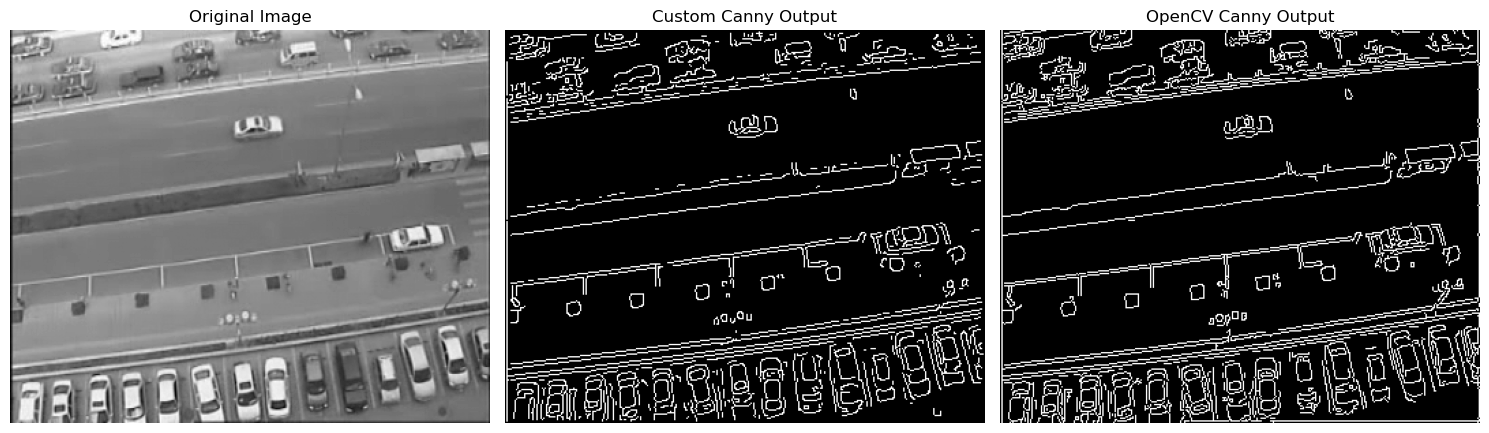

In [34]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("Lab11/LKframe1.png", cv2.IMREAD_GRAYSCALE)
custom_canny_output = cannyedge("Lab11/LKframe1.png")
low_threshold =  100
high_threshold = 200
opencv_canny_output = cv2.Canny(image, low_threshold, high_threshold)


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(custom_canny_output, cmap='gray')
plt.title('Custom Canny Output')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(opencv_canny_output, cmap='gray')
plt.title('OpenCV Canny Output')
plt.axis('off')

plt.tight_layout()

plt.show()

In [35]:
def custom_canny_edge(image, kernel_size=5,sigma=1,lowThresholdRatio=0.05, highThresholdRatio=0.09):
  kernel = gaussian_kernel(kernel_size, sigma)
  result_image = convolve(image, kernel)
  gradient_magnitude, gradient_direction = sobel_filters(result_image)
  final_image = non_max_suppression(gradient_magnitude, gradient_direction)
  res,weak,strong = threshold(final_image)
  return hysteresis(res,weak,strong)

In [46]:
frames = FrameCapture("Lab11/sample1.mp4")
custom_edges=[]
cv2_edges = []

In [43]:
for i in range(15):
    gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    custom_edges.append(custom_canny_edge(gray))
    #cv2_edges.append(cv2.Canny(gray,100,200))
    
    print(f"Frame {i+1} done")

Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Frame 10 done
Frame 11 done
Frame 12 done
Frame 13 done
Frame 14 done
Frame 15 done


In [45]:
import cv2
import numpy as np

output_video_path = 'minions.avi'
fps = 3  # Frames per second
frame_width, frame_height = frames[0].shape[1], frames[0].shape[0]
output_video_size = (frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter(output_video_path, fourcc, fps, output_video_size)

for frame_diff in custom_edges:
    frame_diff = np.clip(frame_diff, 0, 255).astype(np.uint8)
    
    if len(frame_diff.shape) == 2:
        frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_GRAY2BGR)
    
    out.write(frame_diff)

out.release()

print("Video created successfully!")

Video created successfully!


In [47]:
for i in range(len(frames)-1):
    gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    #custom_edges.append(custom_canny_edge(gray))
    cv2_edges.append(cv2.Canny(gray,100,200))
    
    print(f"Frame {i+1} done")

Frame 1 done
Frame 2 done
Frame 3 done
Frame 4 done
Frame 5 done
Frame 6 done
Frame 7 done
Frame 8 done
Frame 9 done
Frame 10 done
Frame 11 done
Frame 12 done
Frame 13 done
Frame 14 done
Frame 15 done
Frame 16 done
Frame 17 done
Frame 18 done
Frame 19 done
Frame 20 done
Frame 21 done
Frame 22 done
Frame 23 done
Frame 24 done
Frame 25 done
Frame 26 done
Frame 27 done
Frame 28 done
Frame 29 done
Frame 30 done
Frame 31 done
Frame 32 done
Frame 33 done
Frame 34 done
Frame 35 done
Frame 36 done
Frame 37 done
Frame 38 done
Frame 39 done
Frame 40 done
Frame 41 done
Frame 42 done
Frame 43 done
Frame 44 done
Frame 45 done
Frame 46 done
Frame 47 done
Frame 48 done
Frame 49 done
Frame 50 done
Frame 51 done
Frame 52 done
Frame 53 done
Frame 54 done
Frame 55 done
Frame 56 done
Frame 57 done
Frame 58 done
Frame 59 done
Frame 60 done
Frame 61 done
Frame 62 done
Frame 63 done
Frame 64 done
Frame 65 done
Frame 66 done
Frame 67 done
Frame 68 done
Frame 69 done
Frame 70 done
Frame 71 done
Frame 72 done
F

In [48]:
import cv2
import numpy as np

output_video_path = 'sample1_output_cv2.avi'
fps = 30  # Frames per second
frame_width, frame_height = frames[0].shape[1], frames[0].shape[0]
output_video_size = (frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter(output_video_path, fourcc, fps, output_video_size)

for frame_diff in cv2_edges:
    frame_diff = np.clip(frame_diff, 0, 255).astype(np.uint8)
    
    if len(frame_diff.shape) == 2:
        frame_diff = cv2.cvtColor(frame_diff, cv2.COLOR_GRAY2BGR)
    
    out.write(frame_diff)

out.release()

print("Video created successfully!")

Video created successfully!


Task 3

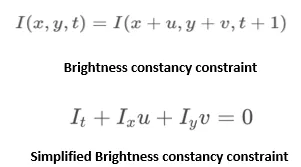

Optical flow is only valid in regions where<br>
When eigenvalues are small, there is no gradient in all directions, it is likely we are looking at pixels over a flat area that don’t show any correlation, like the river in the image above. When eigenvalues show a large ratio, 1 strong, 1 weak gradient, it means we’re looking at an edge, eg the riverbank. This collection is only useful for determining either u or v but not both since we can clearly see when we move laterally, but if we move up the edge, from the camera’s point-of-view we might not be moving at all.

Where we find large eigenvalues, that’s where we know it is a highly textured region of the image that serves as a good collection of pixels to track.

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def inRange( cordinates, limits):
	x,y = cordinates
	x_limit, y_limit = limits
	return 0 <= x and x < x_limit and 0 <= y and y<y_limit


def optical_flow(I1, I2, window_size=5, min_quality=0.01):
    max_corners = 10000
    min_distance = 0.1
    feature_list = cv2.goodFeaturesToTrack(I1, max_corners, min_quality, min_distance)

    w = int(window_size/2)

    I1 = I1 / 255
    I2 = I2 / 255

    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    kt = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], np.float32)
    Ix = convolve(I1, Kx)
    Iy = convolve(I2, Ky)
    It = convolve(I1, kt)-convolve(I2, kt)

    u = np.zeros(I1.shape)
    v = np.zeros(I2.shape)

    for feature in feature_list:        
            j, i = feature.ravel()		#   get cordinates of the corners (i,j). They are stored in the order j, i
            i, j = int(i), int(j)		#   i,j are floats initially

            I_x = Ix[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = Iy[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = It[i-w:i+w+1, j-w:j+w+1].flatten()

            b = np.reshape(I_t, (I_t.shape[0],1))
            A = np.vstack((I_x, I_y)).T

            U = np.matmul(np.linalg.pinv(A), b)     # Solving for (u,v) i.e., U

            u[i,j] = U[0][0]
            v[i,j] = U[1][0]
 
    return (u,v)




img1 = cv2.imread("Lab11/LKframe1.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("Lab11/LKframe2.png", cv2.IMREAD_GRAYSCALE)

U, V = optical_flow(img1, img2, 5, 0.05)

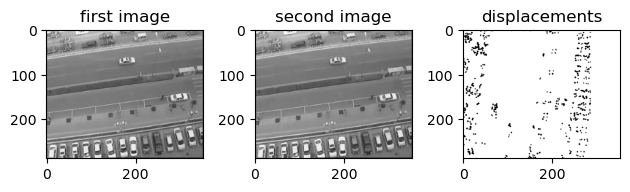

In [81]:
def drawSeperately(I1, I2, u, v):
    displacement = np.ones_like(I1)
    displacement.fill(255.)             #Fill the displacement plot with White background
    line_color =  (0, 0, 0)

    for i in range(I1.shape[0]):
        for j in range(I1.shape[1]):

            start_pixel = (i,j)
            end_pixel = ( int(i+U[i][j]), int(j+V[i][j]) )

            #check if there is displacement for the corner and endpoint is in range
            if U[i][j] and V[i][j] and inRange( end_pixel, I1.shape ):     
                displacement = cv2.arrowedLine( displacement, start_pixel, end_pixel, line_color, thickness =2)

    figure, axes = plt.subplots(1,3)
    axes[0].imshow(I1, cmap = "gray")
    axes[0].set_title("first image")
    axes[1].imshow(I2, cmap = "gray")
    axes[1].set_title("second image")
    axes[2].imshow(displacement, cmap = "gray")
    axes[2].set_title("displacements")
    figure.tight_layout()


drawSeperately(img1, img2, U, V)

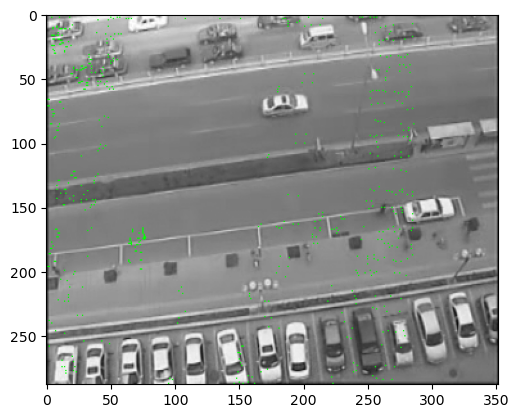

In [82]:
def drawOnFrame(frame, U, V):

    line_color = (0, 255, 255)

    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            u, v = U[i][j], V[i][j]
            if u and v:
                frame = cv2.arrowedLine(frame, (i, j), (int(round(i+u)), int(round(j+v))), (0, 255, 255), thickness=1)
    return frame
img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
plt.imshow(drawOnFrame(img2, U, V))
plt.show()

In [ ]:

video_path = 'Lab11/Sample3.mpg'
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_path = 'optical_flow.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

ret, old_frame = cap.read()
old_frame_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

while True:
  
    ret, new_frame = cap.read()
    if not ret:
        break
    new_frame_gray = cv2.cvtColor(new_frame, cv2.COLOR_BGR2GRAY)

    U, V = optical_flow(old_frame_gray, new_frame_gray, window_size=3, min_quality=0.01)


    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            u, v = U[i][j], V[i][j]
            if u != 0 and v != 0:
                end_point = (int(round(j + u)), int(round(i + v)))
                new_frame = cv2.arrowedLine(new_frame, (j, i), end_point, (0, 255, 0), thickness=1)

    out.write(new_frame)
    old_frame_gray = new_frame_gray


cap.release()
out.release()
cv2.destroyAllWindows()
